In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la
from functions_parameters.universal_parameters import a, b
from functions_parameters.tools import rot_symm_m_check_d, translation_check_d, array_print
from itertools import product

In [2]:
final_result = np.load('u_v1_v2_t_4_em4_random_basis_mesh_30_2_2_pmap_over_filling.npz')


final_ground_state_e_diff_density = final_result['gse']
final_density = final_result['d']
final_bond = final_result['bond']
final_e_difference = final_result['e_diff']
final_c_difference = final_result['c_diff']
final_e_fermi = final_result['e_fermi']
final_iteration = final_result['iters']
any_bi_fail = final_result['any_bi_fail']

u_arr = final_result['u']
filling_arr = final_result['filling']
filling_mesh, u_mesh = np.meshgrid(filling_arr, u_arr, indexing = 'ij')

In [3]:
np.max(final_c_difference)

np.float64(0.0005151632418366183)

In [4]:
np.max(final_e_difference)

np.float64(1.416074107085663e-06)

In [5]:
np.all(np.logical_not(any_bi_fail))

np.True_

### Some points do not converge that well, but ignore it first

In [6]:
index_c_diff = np.where(np.abs(final_c_difference)>1E-4)
final_ground_state_e_diff_density[index_c_diff] = 0
index_e_diff = np.where(np.abs(final_e_difference)>1E-4)
final_ground_state_e_diff_density[index_e_diff] = 0

In [7]:
index_c_diff

(array([ 5,  5,  5,  5,  5,  7,  7,  8, 11, 19, 19]),
 array([ 8,  8,  8,  8,  8,  4, 15,  2,  8, 15, 15]),
 array([ 6,  7, 13, 14, 19,  4, 15, 11,  5,  9, 16]))

In [8]:
final_c_difference[index_c_diff]

array([0.00024628, 0.00051516, 0.00019119, 0.00018391, 0.00013063,
       0.00022733, 0.00012278, 0.00014084, 0.00044952, 0.00015696,
       0.00016537])

### Phase Analysis

In [9]:
sorted_ground_state_e_index = np.argsort(final_ground_state_e_diff_density, axis=2)
sorted_ground_state_e= np.take_along_axis(final_ground_state_e_diff_density, sorted_ground_state_e_index, axis=2)
sorted_density = np.take_along_axis(final_density, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis], axis=2)
sorted_bond = np.take_along_axis(final_bond, sorted_ground_state_e_index[:,:,:,np.newaxis,np.newaxis,np.newaxis,np.newaxis,np.newaxis], axis=2)
sorted_e_difference = np.take_along_axis(final_e_difference, sorted_ground_state_e_index, axis=2)
sorted_c_difference = np.take_along_axis(final_c_difference, sorted_ground_state_e_index, axis=2)

In [10]:
from functions_parameters.universal_parameters import phase_tot, threshold, c_6_2_uc, c_3_2_uc, c_2_2_uc, translation_a1, translation_a2, translation_a3
from functions_parameters.tools import phase_check_nematic_magnetic

phase_diagram_based_on_d = np.zeros((filling_mesh.shape))
nematic_measure = np.zeros((filling_mesh.shape), np.float64)
ts_check = np.zeros((filling_mesh.shape), np.int32)
f_phase = np.zeros((filling_mesh.shape), np.int32)
f_measure = np.zeros((filling_mesh.shape), np.float64)
f_max_measure = np.zeros((filling_mesh.shape), np.float64)

for i in range(filling_mesh.shape[0]):
    for j in range(filling_mesh.shape[1]):
        d_ij = sorted_density[i,j,0]
        ts_recording = np.zeros((3))
        ts_diff_arr = translation_check_d(d_ij, translation_a1, translation_a2, translation_a3)
        if np.all(ts_diff_arr<threshold):
            ts_recording[0] = 1
        elif np.all(ts_diff_arr>threshold):
            ts_recording[-1] = 1
        else:
            ts_recording[1] = 1
        ts_check[i,j] = np.argmax(ts_recording)
        rs_recording, m_recording, c6_diff, magnetism_arr = phase_check_nematic_magnetic(d_ij, c_6_2_uc, c_3_2_uc, c_2_2_uc)
        nematic_measure[i,j] = c6_diff
        f_phase[i,j] = np.argmax(m_recording)
        f_measure[i,j] = np.mean(np.abs(magnetism_arr))
        f_max_measure[i,j] = np.max(np.abs(magnetism_arr))
        phase_arr = np.kron(ts_recording,rs_recording)
        phase_arr = np.kron(phase_arr,m_recording)
        phase = np.argmax(phase_arr)
        phase_diagram_based_on_d[i,j] = phase

unique_phase_index = np.unique(phase_diagram_based_on_d)
unique_phase_name = [phase_tot[i] for i in np.int_(unique_phase_index)]
filtered_phase_diagram = np.zeros(phase_diagram_based_on_d.shape)
for i in range(filling_mesh.shape[0]):
    for j in range(filling_mesh.shape[1]):
        filtered_phase_diagram[i,j] = np.where(unique_phase_index==phase_diagram_based_on_d[i,j])[0][0]

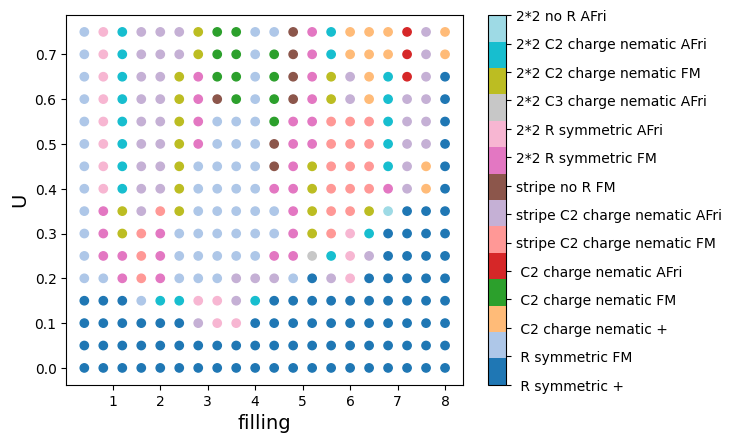

In [11]:
cmap = plt.get_cmap("tab20", len(unique_phase_index))
plt.scatter(filling_mesh, u_mesh, c=filtered_phase_diagram, cmap=cmap)
plt.xlabel('filling', size = '14')
plt.ylabel('U', size = '14')
colorbar_ticks = np.arange(len(unique_phase_index))
cbar = plt.colorbar()
cbar.set_ticks(np.arange(len(unique_phase_index)))
cbar.set_ticklabels(unique_phase_name)

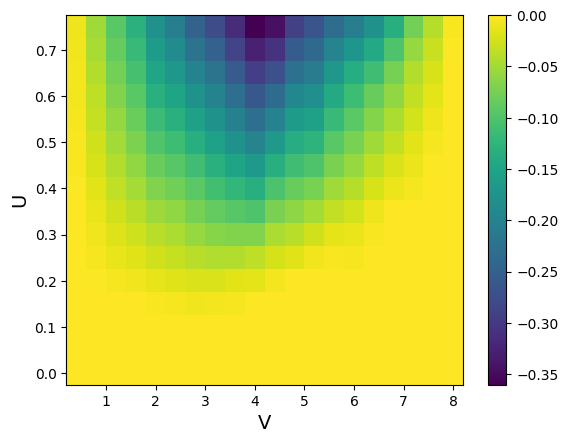

In [12]:
plt.pcolormesh(filling_mesh,u_mesh,sorted_ground_state_e[:,:,0])
plt.xlabel('V', size = '14')
plt.ylabel('U', size = '14')
plt.colorbar()

In [13]:
np.mean(final_iteration)

np.float64(74.44703125)

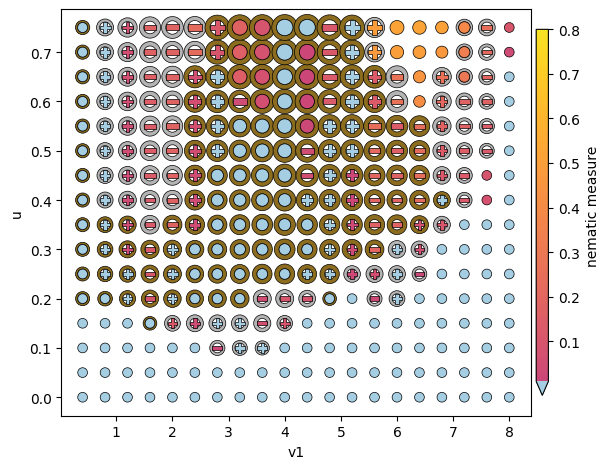

In [14]:
from functions_parameters.phase_plot import PlotConfig, plot_phase_map

CFG = PlotConfig(nem_vmax=0.8)
fig, ax = plt.subplots()
plot_phase_map(
    fig,
    ax,
    filling_mesh, u_mesh,
    sorted_ground_state_e/4,               # [...,0] read inside
    nematic_measure,
    ts_check, f_phase,
    f_max_measure,                       # or f_measure if you prefer mean
    cfg=CFG,
)
ax.set_xlabel("v1")
ax.set_ylabel("u")
plt.tight_layout(); plt.show()

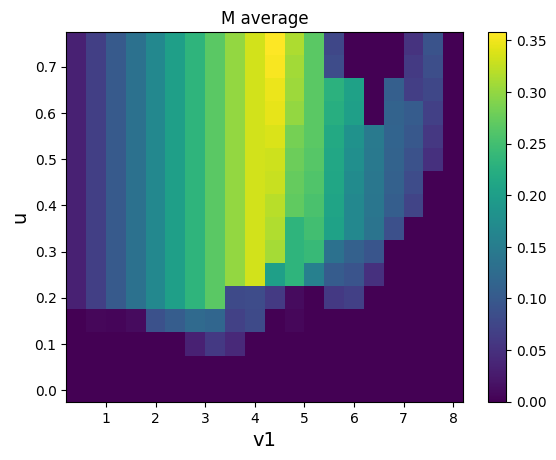

In [15]:
plt.pcolormesh(filling_mesh, u_mesh, f_measure)
plt.colorbar()
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
plt.title('M average')
plt.show()

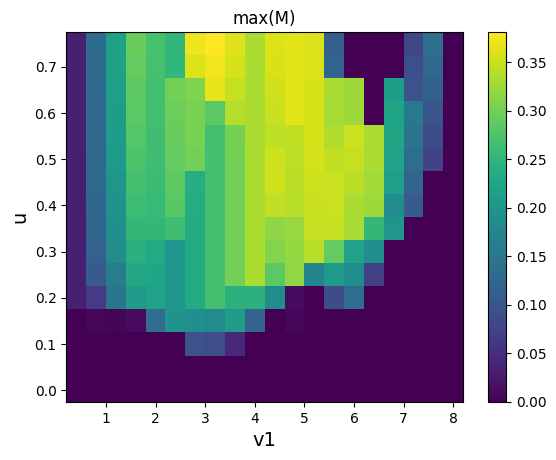

In [16]:
plt.pcolormesh(filling_mesh, u_mesh, f_max_measure)
plt.colorbar()
plt.xlabel('v1', size = '14')
plt.ylabel('u', size = '14')
plt.title('max(M)')
plt.show()